In [1]:
import rosbag
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
# import std_msgs.msg

# 路径替换为你的ROS bag文件路径
bag_path = '/home/hxl/Downloads/agress_traj_cut.bag'

# 初始化存储数据的列表
thr_norm_data = []
est_a_norm_data = []
timestamps = []

# 从ROS bag中提取数据

with rosbag.Bag(bag_path) as bag:
    # print(bag)
    for topic, msg, t in bag.read_messages(topics=['/controller/pid']):
        thr_norm_data.append(msg.thr_norm.data)
        est_a_norm_data.append(msg.est_a_norm.data)
        timestamps.append(t.to_sec())
print(len(thr_norm_data))
print(len(est_a_norm_data))
print(len(timestamps))

thr_norm_data = np.array(thr_norm_data)
est_a_norm_data = np.array(est_a_norm_data)
timestamps = np.array(timestamps)
# stack thr_norm_data and est_a_norm_data and timestamps
data = np.column_stack((timestamps, thr_norm_data, est_a_norm_data))
print(data.shape)

# delete those rows which thr_norm_data do not changed between two timestamps
data = data[np.where(np.diff(data[:, 1]) != 0)]
print(data.shape)
timestamps = data[:, 0]
normalized_time = (timestamps - timestamps[0])/(timestamps[-1] - timestamps[0])

750
750
750
(750, 3)
(468, 3)


In [2]:
def update_plot(time_point):
    # 更新图表
    plt.figure(figsize=(10, 12))

    # 第一个子图
    plt.subplot(211)
    plt.plot(normalized_time, 15*data[:, 1], label='thr_norm_data')
    plt.plot(normalized_time, data[:, 2], label='est_a_norm_data')
    plt.axvline(x=normalized_time[time_point], color='k', linestyle='--')
    plt.xlabel('Normalized Time')
    plt.ylabel('Data')
    plt.legend()
    plt.grid(True)

    # 第二个子图
    plt.subplot(212)
    plt.scatter(data[:, 1], data[:, 2], c=normalized_time, cmap='coolwarm', alpha=0.5)
    plt.scatter(data[time_point, 1], data[time_point, 2], c='black', s=100)  # 高亮显示当前时间点
    plt.xlabel('thr_norm_data')
    plt.ylabel('est_a_norm_data')
    plt.colorbar(label='Normalized Time')
    plt.legend(['thr_norm_data vs est_a_norm_data'])
    plt.grid(True)
    plt.show()

# 交互式控件
interact(update_plot, time_point=(0, len(data) - 1))

interactive(children=(IntSlider(value=233, description='time_point', max=467), Output()), _dom_classes=('widge…

<function __main__.update_plot(time_point)>

pcov1:  [[0.80482897 0.0319392 ]
 [0.0319392  0.00127331]]
pcov2:  [[0.002026]]
popt1:  [31.69334286  0.70972769]
popt2:  [20.28191178]


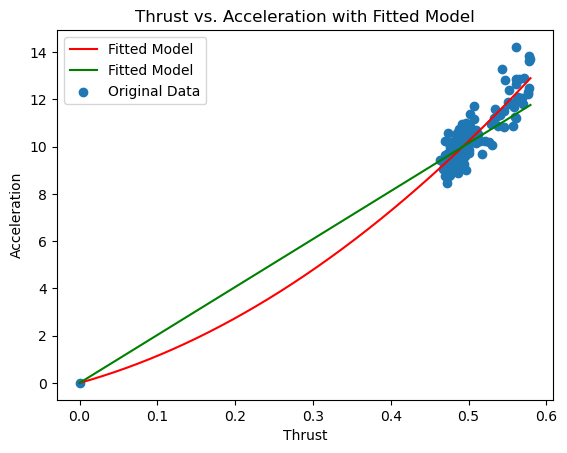

In [3]:
from scipy.optimize import curve_fit

# 假设你已经有了thr和acc数据
thr = data[:, 1]
acc = data[:, 2]

# 定义模型函数
def model1(thr, K1, K2):
    return K1 * (K2 * thr**2 + (1 - K2) * thr)
def model2(thr, K):
    return K * thr

# 使用curve_fit来估计参数
popt1, pcov1 = curve_fit(model1, thr, acc)
popt2, pcov2 = curve_fit(model2, thr, acc)

print("pcov1: ", pcov1)
print("pcov2: ", pcov2)
print("popt1: ", popt1)
print("popt2: ", popt2)
# 生成预测曲线的推力值
thr_pred = np.linspace(np.min(thr), np.max(thr), 500)
# 计算预测曲线的加速度值
acc_pred1 = model1(thr_pred, *popt1)
acc_pred2 = model2(thr_pred, *popt2)

# 绘制原始数据的散点图
plt.scatter(thr, acc, label='Original Data')

# 绘制模型预测的曲线
plt.plot(thr_pred, acc_pred1, color='red', label='Fitted Model')
plt.plot(thr_pred, acc_pred2, color='green', label='Fitted Model')

plt.xlabel('Thrust')
plt.ylabel('Acceleration')
plt.title('Thrust vs. Acceleration with Fitted Model')
plt.legend()
plt.show()




In [5]:
def solve_thr(acc, K1, K2):
    a = K1 * K2
    b = K1 * (1 - K2)
    c = -acc

    # 计算判别式
    discriminant = b**2 - 4*a*c

    # 检查判别式是否为正，确保根是实数
    if discriminant >= 0:
        root1 = (-b + np.sqrt(discriminant)) / (2 * a)
        root2 = (-b - np.sqrt(discriminant)) / (2 * a)
        return root1, root2
    else:
        return None, None  # 无实数解

# 示例：给定目标加速度，以及估计的K1和K2
target_acc = 9.8  # 目标加速度
K1_estimated = 31.69334286  # 示例K1值
K2_estimated = 0.70972769  # 示例K2值

thr1, thr2 = solve_thr(target_acc, K1_estimated, K2_estimated)
print("Possible thrust values:", thr1, thr2)


Possible thrust values: 0.4865160837746795 -0.8955071856999827
